In [10]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import generate_timestep
from tqdm import tqdm

hydra.initialize(config_path="cfg_long_hal", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=Burgers"])

In [5]:
with h5py.File(cfg.dataset.train_path, 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)

In [4]:
# with h5py.File('data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)

In [9]:
traj[0,0].shape

torch.Size([256])

In [12]:

class ComputePSDiff():
    def __init__(self,N,L,device):
        self.N = N
        self.L = L
        self.device = device

        k = torch.arange(0,N,dtype = torch.float32)
        k[(N+1)//2:] = k[(N+1)//2:]-N
        
        self.k = k
        
    def __call__(self,u,order=1,dim=1,device = None):
        # compute psdiff
        device = self.device if device is None else device
        assert u.shape[dim] == self.N
        
        k = self.k.to(device)
        
        if (order %2 == 1) & (self.N % 2 == 0):
            k[self.N//2] = 0
            
        coeff_shape = [1 if i!=dim else -1 for i in range(len(u.shape))]
        coeff = torch.pow(2j *torch.pi * k/ self.L, order).view(coeff_shape)
        f = torch.fft.fft(u,dim=1)
        df = f * coeff
        du = torch.fft.ifft(df,dim=1)
        return du.real

psdiff = ComputePSDiff(256,128,device)



In [19]:
def to_burgers(psi: torch.Tensor, device = None):
    # cole-hopf transformation 
    # psi has shape (nt,nx)
    
    psix = psdiff(psi,order = 1,device = device)
    return  - (psix / psi) * (2 * 0.01)


def inv_cole_hopf(psi0: np.ndarray, scale: float = 10.) -> np.ndarray:
    """
    Inverse Cole-Hopf transformation to obtain Heat equation out of initial conditions of Burgers' equation.
    Args:
        psi0 (np.ndarray): Burgers' equation (at arbitrary timestep) which gets transformed into Heat equation
        scale (float): scaling factor for transformation
    Returns:
        np.ndarray: transformed Heat equation
    """
    psi0 = psi0 - np.amin(psi0)
    psi0 = scale * 2 * ((psi0 / np.amax(psi0)) - 0.5)
    psi0 = np.exp(psi0)
    return psi0

In [24]:

inv = inv_cole_hopf(traj[0:1,0].numpy())
ret = to_burgers(torch.tensor(inv).to(device),device = device)

print(ret.cpu() - traj[0:1,0])

tensor([[ 2.1505e+02, -1.6651e+02,  1.2830e+02, -9.7910e+01,  7.5247e+01,
         -5.7130e+01,  4.3775e+01, -3.3124e+01,  2.5428e+01, -1.9058e+01,
          1.4744e+01, -1.1023e+01,  8.5542e+00, -6.2902e+00,  4.9862e+00,
         -3.6117e+00,  2.9230e+00, -2.0702e+00,  1.7351e+00, -1.1630e+00,
          1.0254e+00, -6.4586e-01,  6.2095e-01, -3.5436e-01,  3.8026e-01,
         -1.8634e-01,  2.3779e-01, -9.3106e-02,  1.5139e-01, -4.3164e-02,
          9.7872e-02, -1.7514e-02,  6.2384e-02, -6.5725e-03,  3.7955e-02,
         -4.0041e-03,  2.0297e-02, -6.0600e-03,  6.0848e-03, -1.1184e-02,
         -5.9242e-03, -1.7829e-02, -1.6639e-02, -2.5450e-02, -2.6649e-02,
         -3.3645e-02, -3.6206e-02, -4.2141e-02, -4.5514e-02, -5.0838e-02,
         -5.4667e-02, -5.9639e-02, -6.3729e-02, -6.8495e-02, -7.2749e-02,
         -7.7390e-02, -8.1732e-02, -8.6302e-02, -9.0697e-02, -9.5225e-02,
         -9.9650e-02, -1.0415e-01, -1.0860e-01, -1.1308e-01, -1.1753e-01,
         -1.2201e-01, -1.2646e-01, -1.

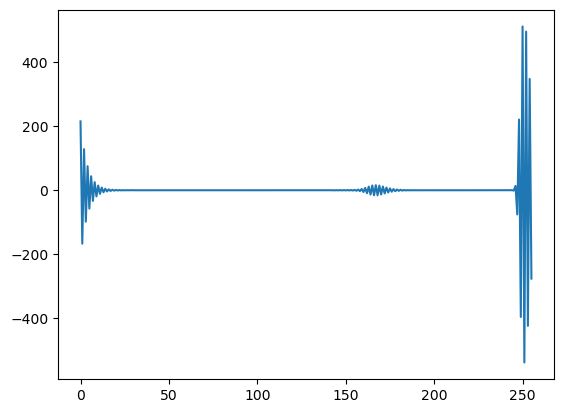

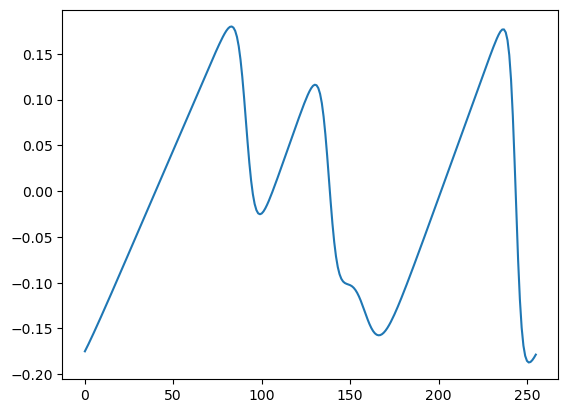

In [28]:
plt.figure()
plt.plot(ret[0].cpu())

plt.figure()
plt.plot(traj[0,0].cpu())

In [5]:

x = traj[0:1000, 0, :]

solution = []
y_pred = x
solution.append(y_pred)
for i in tqdm(range(5)):
    y_pred = generate_timestep(y_pred, 0, cfg)
    solution.append(y_pred)
solution = torch.cat(solution, dim=0)

real = traj[0, :131, :]

plt.figure()
plt.imshow(solution.T)
plt.colorbar()

plt.figure()
plt.imshow(real.T)
plt.colorbar()

  0%|          | 0/5 [00:01<?, ?it/s]


KeyboardInterrupt: 